# Multi-Agent Reinforcement Learning (MARL)

![MARL.PNG](assets/images/MARL.PNG)

## Definitions

Let's start with wikipedia's informal definition:

![](assets/images/Wiki.PNG)

So MARL has its own page on Wiki! It relates to single-agent RL, Multi agent systems and game theory. MARL adds reciprocity concepts to single-agent RL. Some known and recent applications of MARL are __multi-drone control, playing GO, Poker and Starcraft__.

![](assets/images/Applications.PNG)

There are several representations for a MARL problem, as we can see in the following figure. The problems can be categorised along a number of axes. First, whether the environment is fully or partially __observable__. Second, whether the nature of the interaction is __collaborative, mixed or competitive__. Third, whether turns are taken __sequentially or simultaneously__. Different problem representations come with different challenges. The four main challenges include computational complexity, non-stationarity, partial observability and credit
assignment.

![](assets/images/ProblemsAndIssues.PNG)

In the following schemes of our problems, we can see the main difference between __MDP__ and __Markov Game__ when in Markov game we have several agents, each with its own reward and actions. __Partially Observable Markov Game (POMG)__ only adds observations instead of states. In __Dec-POMDP__, we have a POMG with joint reward, and in __Extensive Form Games__ there are only rewards in terminal states. Spoiler: The __Multi Taxi environment is a markov game__ (different rewards for taxis), and the __speaker-listener is a Dec-POMDP__ (same reward for speaker and listener).

![](assets/images/MARLProblemsComparison.PNG)

## Main Model

As we saw in class and right now, the mose expressive (and expensive) model with full observability is the markov game. Here is it's formal definition, as a reminder:

![](assets/images/SGDefinition.PNG)

Now, __each agent__ aims to find a behavioural policy (or, a mixed strategy in game theory) that can guide the agent to take sequential actions such that the discounted cumulative reward
in the following equation is maximized:

![](assets/images/MarkovGamesObjective.PNG)

One common goal, which has been challenged by Shoham, is the convergence to __Nash equilibrium__. By definition, NE characterizes the point that no agent will deviate from, if any algorithm finally converges. This is undoubtedly a reasonable solution concept in game theory, under the assumption that the agents are all rational, and are capable of perfectly reasoning and infinite mutual modeling of agents. However, with bounded rationality, the agents may only be able to perform finite mutual modeling. In addition to the goals concerning __optimizing the return__, several other goals that are special to multi-agent systems have also drawn increasing attention. For example, __learning to communicate__, in order for the agents to better coordinate. Other important goals include how to __learn without over-fitting__ certain agents , and how to __learn robustly with either malicious/adversarial or failed/dysfunctional__ learning agents. There is plenty of room for theoretical studies.

## Training Schemes

Now, how to solve these problems with RL? In the following figure we can see the three main training schemes in multiagent settings:  __Centralized training and decentralized execution__, using a __Centralized controller__ and __Independent learning__. The most popular approach is centralised training with decentralised execution, in which agents are allowed to share information during training, but actions are executed decentrally based on local observations. Using a centralised controller reduces the problem to a single-agent problem but is computationally infeasible. Finally, independent learners consider other agents as part of the environment but ignore the non-stationarity problem. Spoiler 2: __We implemented the centralized controller training method, and the independent learners scheme.__

![](assets/images/TrainingSchemesOnAxis.PNG)

The __centralized controller__ and the __independent learners__ are in both sides of the training schema spectrum. They are important as simple, __black-box__ approaches and as a __baseline__ which other methods should prove they can beat significantly. Although centralized and independent learners can be used as a black-box (Their interface is composed only from observations and actions), one can think of a straightforward extension of centralized Q-Learning to Markov game with joint actions in the computation of Q-values. 
Thus, the update equation in a centralized view is ![](assets/images/JAL-Q.PNG) 

For independent learners, the Q-learning update equation is ![](assets/images/IL-Q.PNG)

Another independent approach, by Claus and Boutilier, 1998, is to try to explicitly maintain a belief regarding the likelihood of the other agents’ policies,and update V based the induced expectation of the Q values:
![](assets/images/V_With_Belief.PNG) 

Now, __how can we exchange information during training?__ Here are some examples:

Nash-Q learning, by Hu and Wellman, 1998, is another generalization of Q-learning to general-sum games. Nash-Q updates the V-values based on some Nash-equilibrium in the game defined by the Q-values:
![](assets/images/Nash-Q.PNG)

Of course in general there are many Nash equilibria, and therefore the Nash payoff may not be unique. If Nash-Q is taken to apply to all general-sum Markov games, it must be interpreted as a nondeterministic procedure.

In Matta et al., 2019, An algorithm called Q-RTS is proposed with the following update rules:

![](assets/images/Qswarm.PNG)
![](assets/images/Qswarm2.PNG)

The key idea is to use a centralized aggregation center to combine all the Q-value tables of the agents to form a global swarm matrix containing the highest and lowest Q-values representing the most interesting iterations by the agents. The swarm matrix is then linearly combined into the local Q-value matrix of each agent, using an independence factor controlling the tradeoff of local and global knowledge.


__References:__

1. Multi-Agent Reinforcement Learning: A Review of Challenges and Applications, Canese at el., 2021
2. Multi-Agent Reinforcement Learning: A Selective Overview of Theories and Algorithms, Kaiqing el al., 2019
3. An Overview of Multi-Agent Reinforcement Learning from Game Theoretical Perspective, Yaodong et al., 2020
4. Multiagent Deep Reinforcement Learning: Challenges and Directions Towards Human-Like Approaches, Wong et al., 2021
5. Multi-Agent Reinforcement Learning: a critical survey, Shoham et al., 2003
6. Q-RTS: a real-time swarm intelligence based on multi-agent Q-learning, Matta et al., 2019

### If running with google colab:
1. uncomment and run the next code cell.
2. create an empty directories with the names `src` and `tmp`.
3. uplode the contant of the directory `tut09/src` into the empty `src` directory on colab.

In [1]:
# # installing easily via pip (uncomment if running from google colab)
# !pip install torch
# !pip install gym
# !pip install -q 'git+https://github.com/sarah-keren/multi-taxi'
# !pip install -q 'git+https://github.com/sarah-keren/MAC'

# Pre-Implementation

### Imports

In [2]:
import os
import sys
import torch as T
import numpy as np
import copy as cp
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
from mac.environments.env_wrapper import EnvWrappperMultiTaxi
from mac.agents import Agent, DecisionMaker, RandomDecisionMaker
from mac.control.controller_decentralized import DecentralizedController
from mac.control.controller_centralized import CentralizedController
from multi_taxi import MultiTaxiEnv
from src.utils_controller import (DecentralizedRlController, CentralizedRlController,
                                  create_decentralized_agent, create_centralized_agent)
from src.agents import DqnDecisionMaker
from src.utils import plot_multi_taxi_learning_curve
sys.path.append("./src")

/usr/local/Caskroom/miniconda/base/envs/fstma-tut09/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



### Environment maps

In [3]:
simple_MAP = [
    "+---------+",
    "| : : : : |",
    "| : : : : |",
    "| : : : : |",
    "| : : : : |",
    "| : : : : |",
    "+---------+",
]

### Seeding everything for experimental reproducibility

In [4]:
SEED = 42
np.random.seed(SEED) # numpy
T.manual_seed(SEED)  # torch
random.seed(SEED)    # random

## Multi-Taxi Domain


In [5]:
# set up the environment
taxi_env = MultiTaxiEnv(num_taxis=2, num_passengers=2, can_see_others=False)

# wrap environment to be MAC compatible
taxi_env = EnvWrappperMultiTaxi(taxi_env)

# render
taxi_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : :D|
| : : : : :P| : : : : : |
| :P: : :D: | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | |_: | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (6,9), Collided: False
Taxi1-RED: Fuel: inf, Location: (4,4), Collided: False
Passenger1: Location: (3, 5), Destination: (2, 11)
Passenger2: Location: (4, 1), Destination: (4, 4)
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]


# Controlling Methods with Random Agents

1. Centralized controller with a random decision maker (Agent)
2. Decentralized controller with a few random decision makers (Agents)

#### Abstract parent class for a generalized Controller (MAC package compatible)

We are using the abstract Controller (from MAC) as a parent class for our controllers. It is intitialized only with the environment, and it has a few base functions already implemented which we can use or override:
- ```python
def run(self, render=False, max_iteration=None):
``` 
which is for using the Controller to run the environment.

- ```python
def perform_joint_action(self, joint_action):
```
which is for performing a joint action __regardless__ if it is generated in a __centralized__ or a __decentralized__ manner.

- ```python
@abstractmethod
def get_joint_action(self, observation):
    pass
```
which is implemented as an abstract method for the child class to decide if should be centralized or decentralized.


### The Main Differences Between Centralized and Decentralized Controllers (in discrete actions spaces)

In our implementation both __Centralized__ and __Decentralized__ controllers inherits from the abstract `Controller` class of mac. There are two main differences between the two: 
1. An agent's action space and the way the `get_joint_action()` function is implemented.
2. An agent's observation space and the way a state is communicated to the agents.

#### Decentralized Controller Action Space
In the Decentralized setting, each player (i.e. a taxi in the __Multi Taxi__ domain) is being controlled via a single agent. Therefore, the action space of the agent is determined from the dimension of a single player action space. For example, a taxi in the Multi-Taxi domain (under the settings we are working in) can act in the environment by performing the next actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: dropoff passenger

Therefore, the action space has $6$ dimensions. This determines each one of the $m$ taxi-agents in a decentralized control setting to also have an action space with $6$ dimensions. In that setting, the `get_joint_action()` function is implemented by iterating over all the players in the environment, each is controlled by its own agent, and compute there actions one by one, resulting in a set of actions for all the players.


#### Cecentralized Controller Action Space

In the Centralized setting, a single agent is used for controlling __all__ the players in the environment. Therefore, the output of the `get_joint_action()` function is no longer a set of actions in a low-dimensional action-space, but a single action in a high-dimensional action-space, which results as an integer $k\in[0, n^m-1]$, where
- $k$ is the centralized agent's action.
- $n$ is a single player action-space dimension (i.e a `taxi_0`).
- $m$ is the number of players in the environmet (i.e the number of taxis).

__note:__ there is a hidden assumption in the derivation above that all the players in the environment have the same action space dimension, in domains which this is not the case (i.e speaker-listener) the derivation would be a little different.

Notice that in order to `step()` the environment, we first need to break the central agent's action into actions of individual players in the environment. We do that using a `decode_action()` function which assumes the central agent's action is a base $n$ encoding of individual players actions as follows
$$k=a_0\cdot n^{m-1} + a_1\cdot n^{m-2} +\dots +a_{(m-2)}\cdot n^{1}+a_{(m-1)}\cdot n^{0}$$

#### Centralized vs Decentralized Controllers State Spaces

Depending on the domain there are a lot of ways to encode the set of individual players' observations into a single agent observation. For example, in the Multi-Taxi domain, each individual player "sees" only itself, its observation does not contain the information obout other taxis' locations. A way to encode the set of individual observation into a single observation could be by collecting all the infromation from individual observation into a single high-dimensional observation that contains the information of all the taxis at once as follows

__individual $m$ observations:__
- taxi_0 - $[x_0, y_0, pass^{\text{loc&dest}}_0, \dots, pass^{\text{loc&dest}}_l, pass_0^{\text{stat}}, \dots, , pass_l^{\text{stat}}]$
- ...
- taxi_m - $[x_m, y_m, pass^{\text{loc&dest}}_0, \dots, pass^{\text{loc&dest}}_l, pass_0^{\text{stat}}, \dots, , pass_l^{\text{stat}}]$

__high-dimensional single observation:__
- central agent - $[x_0, y_0, \dots x_m, y_m, pass^{\text{loc&dest}}_0, \dots, pass^{\text{loc&dest}}_l, pass_0^{\text{stat}}, \dots, , pass_l^{\text{stat}}]$


### Agent abstract class and a Random Decision Maker class (copied from MAC)
After defining the controllers it is time to define our __Agent__ and __Decision-Makers___.
- An Agent is an object that observe the environment.
- A Decision-Maker is the object that make decisions and choose actions.
- Each Agent may have more than one Decision-Maker. 


```python
class Agent:

    def __init__(self, decision_maker, sensor_function=None, message_filter=None):
        self.decision_maker = decision_maker
        self.sensor_function = sensor_function or (lambda x: x)  # default to identity function
        self.message_filter = message_filter

    def get_decision_maker(self):
        return self.decision_maker

    def get_observation(self, state):
        return self.sensor_function(state)


class DecisionMaker(ABC):
    """
    An abstract class for choosing an action, part of an agent.
    (An agent can have one or several of these)
    """

    @abstractmethod
    def get_action(self, observation):
        pass


class RandomDecisionMaker:
    def __init__(self, action_space):
        self.space = action_space

    def get_action(self, observation):

        #TODO this assumes that the action space is a gym space with the `sample` funcition
        if isinstance(self.space, dict):
            return {agent: self.space[agent].sample() for agent in self.space.keys()}
        else:
            return self.space.sample()
```

## Control with Random-Decision-Makers (Implementation)
### Centralized Controller - Random Decision Maker

In [6]:
# setting up a random decision maker
random_decision_maker = RandomDecisionMaker(taxi_env.action_spaces)

# initialize a central agent
central_agent = Agent(decision_maker=random_decision_maker)

# initialize a centralized controler
centralized_controller = CentralizedController(env=taxi_env, central_agent=central_agent)

Render a run in the environment using a centralized controller with a random decision maker.

In [7]:
centralized_controller.run(render=True, max_iteration=2)

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : :P: : | : :P: : : |
| : : :_:D: : :D: : : : |
| | :G| | | :G| | | : |_|
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (6,11), Collided: False
Taxi1-RED: Fuel: inf, Location: (5,3), Collided: False
Passenger1: Location: (4, 3), Destination: (5, 7)
Passenger2: Location: (4, 8), Destination: (5, 4)
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : :P: : | : :P: : : |
| : : :_:D: : :D: : : : |
| | :G| | | :G| | | : |_|
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (6,11), Collided: False
Taxi1-RED: Fuel: inf, Location: (5,3), Collided: False
Passenger1: Location: (4, 3), Destination: (5, 7)
Passenger2: Location: (4, 8), Destination: (5, 4)
Done: Fals

### Decentralized Controller - Random Decision Makers

In [8]:
# setting up a dictionary of random decision makers, one for each taxi
random_agents = {}
for agent_id in taxi_env.get_env_agents():
    rdm = RandomDecisionMaker(taxi_env.get_action_space(agent_id))
    random_agents[agent_id] = Agent(rdm)

# initialize a decentralized controler
decentralized_controller = DecentralizedController(env=taxi_env, agents=random_agents)

Render a run in the environment using a decentralized controller with a few random decision makers.

In [9]:
decentralized_controller.run(render=True, max_iteration=2)

+-----------------------+
| : |F: | :D|_: | : |D: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | |P:G|P| | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0,5), Collided: False
Taxi1-RED: Fuel: inf, Location: (0,6), Collided: False
Passenger1: Location: (6, 7), Destination: (0, 10)
Passenger2: Location: (6, 5), Destination: (0, 5)
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+-----------------------+
| : |F: | :D|_: | : |D: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | |P:G|P| | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0,5), Collided: False
Taxi1-RED: Fuel: inf, Location: (0,6), Collided: False
Passenger1: Location: (6, 7), Destination: (0, 10)
Passenger2: Location: (6, 5), Destination: (0, 5)
Done: Fals

## Create a Deep Q-Network (DQN) Decision Maker

Here is a quick reminder of the DQN algorithm, with its replay buffer and network replacement, as we saw in previous tutorials:

![](assets/images/DQN.PNG)

### Creating a DQN base class and DQN-Decision-Makers
The DQN base class is, as its name, a base class for DQN algorithm variations. The base class is needed because there are a lot of different DQN-like algorithms (i.e. DQN, DDQN, Dueling-DQN, Dueling-DDQN, etc) and we would want to be compatible with all of them. 

In order to also be compatible with the `Agent` and `DecisionMaker` classes of the `MAC` package, our implemented `DqnDecisionMaker` class follows the classes architecture depicted in the next diagram (where `DecisionMaker` inherits from `ABC`, `DqnBase` inherits from `DecisionMaker` and so on).

![](assets/dqn_inheritance.drawio.png)

__Note:__ The `Agent` class does not inherits from the `DqnDecisionMaker` class but has it as an attribute.

The `DqnBase` gets a __replay buffer__ and a few __neural networks__ as an input (depends on the DQN variation) and handles all the __saving and loading__ of transitions and networks, where every `DqnDecisionMaker` is in charge on the action-choosing and learning-process through the next two functions:

```python
def get_action(self, observation):
    ...
    return action

def learn(self):
    ...

```
__Note:__ Each one of the __DQN__-like algorithms has its own implementation of these two functions.

#### A Multi-Layer Perceptron (MLP) for DQN
The action-value function, $Q(s, a)$ in DQN algorithms is represented using a neural network. A personal choise for us was a three-layer mlp, this could obviously change based on the __efficiency-accuracy__ tradeoff.

## Automatic Generation of Decentralized and Centralized Agents

Using the functions `create_decentralized_agent()` and `create_centralized_agent()` we make the process of creating (or loading) a new agent automatic and Coltroller independent. 

In [10]:
def create_decentralized_agent(policy_name, env, agent_name, kwargs, load_agent=False):
    """
    Creates a decentralized agent
    Args:
        policy_name (str): name of RL algorithm
        env: the multi_taxi env
        agent_name (str): name of the agent
        kwargs (dict): dict parameters for RL algorithm

    Returns: agent

    """
    agent_kwargs = cp.copy(kwargs)
    agent_kwargs['input_dims'] = env.get_observation_space(agent_name).shape
    agent_kwargs['n_actions'] = env.get_action_space(agent_name).n
    agent_kwargs['env_name'] = agent_kwargs['env_name'] + '__' + agent_name

    if policy_name == 'dqn':
        agent = Agent(DqnDecisionMaker(**agent_kwargs))
    
    elif policy_name == 'ddpg':
        raise NotImplementedError
        
    else:
        print('... invalid operation ...')
        return
    print(f'... initialize a decentralized {policy_name} agent for agent {agent_name} ...')
    if load_agent:
        agent.get_decision_maker().load_models()
        print(f'... load a decentralized {policy_name} agent for agent {agent_name} ...')
    return agent



In [11]:
def create_centralized_agent(policy_name, env, agent_name, kwargs, load_agent=False):
    """
    Creates a centralized agent
    Notes:
        Compute the dimension of the joint state space and the joint action space
            [
             agent_0_x, agent_0_y, ..., agent_n_x, agent_0_y,
             pass_0_loc_x, pass_0_loc_y, pass_0_des_x, pass_0_des_y, ...
             pass_m_loc_x, pass_m_loc_y, pass_m_des_x, pass_m_des_y,
             pass_0_status, ..., pass_m, status
            ]

    Args:
        policy_name (str): name of RL algorithm
        env: the multi_taxi env
        agent_name (str): name of the agent
        kwargs (dict): dict parameters for RL algorithm

    Returns: agent

    """

    # compute the observation space
    agents_ids = env.get_env_agents()
    observation_space = list(env.get_observation_space(agents_ids[0]).shape)
    observation_space[0] += 2 * (len(agents_ids) - 1)
    kwargs['input_dims'] = tuple(observation_space)

    # compute the dimension of the joint action space
    kwargs['n_actions'] = int(env.get_action_space(agents_ids[0]).n ** len(agents_ids))

    # name the agent for saving purposes
    kwargs['env_name'] = kwargs['env_name'] + '__' + agent_name
    if policy_name == 'dqn':
        agent = Agent(DqnDecisionMaker(**kwargs))
        
    elif policy_name == 'ddpg':
        raise NotImplementedError
        
    else:
        print('... invalid operation ...')
        return
    print(f'... initialize a centralized {policy_name} agent for agent {agent_name} ...')

    if load_agent:
        agent.get_decision_maker().load_models()
        print(f'... load a centralized {policy_name} agent for agent {agent_name} ...')
    return agent

# Creating the Centralized and Decentralized RL Controllers 
Finally, we are left with the interesting part of creating classes for the RL decentralized and centralized controllers. The main difference between the controllers with random-decision-makers we have seen so far to the Reinforcement Learning ones is that the RL ones can learn how to operate in the environment through experience. Therefore, the RL Controllers have to have a `train()` function implemented so we could train our RL decision makers. It is important that the `train()` function would be independent of the RL algorithm in hand so we could use it in different RL algorithms on different domains.

## Decentralized Reinfrocement Learning Controller

The implementation's architecture is depicted in the diagram below, where the end result is a `DecentralizedRLController` which is MAC complatible  

![](assets/decentralized_rl_controler_inheritance.drawio.png)

The `train()` function of the decentralized RL controller class has a few important aspects it is worth talk about, here is its skeleton


```python
def train(self, render=False, max_iteration=None, max_episode=1):
    ...
    for episode in tqdm(range(max_episode)):
        ...
        done = {'__all__': False}
        observation = self.env.get_env().reset()
        
        while not done['__all__']:            
            ...
            # get actions for all agents and perform
            joint_action = self.get_training_joint_action(observation)
            observation_, reward, done, info = self.perform_joint_action(joint_action)

            # store the joint transition
            self.store_joint_transition(observation, joint_action, reward, observation_, done)

            # distribute rewards
            self.distribute_joint_reward(reward)
            ...
            # perform joint learning for all agents
            self.joint_learning()
            ...   
            # step the state forward
            observation = observation_
    return stuff_for_analysis
```

__Notes:__
- The `observation` received from the environment is transfered to the agent as is.
- Each agent stores its own transition with its own observations, action and reward.
- The learning process is happening in a loop where each agent learns on its own from it own experience.
- In this setting it is also possible to have the agents share the replay buffer and there experiences for more efficient learning (not implemented here).

## Running a Decentralized RL Controller for the Multi-Taxi Domain
### Setting up the parameters

In [12]:
# multi_taxi parameters
num_taxis = 2
num_passengers = 2
can_see_others = False
domain_map = simple_MAP
pickup_only = True

# DQN parameters
kwargs = {
    'gamma': 0.99,
    'epsilon': 1.0,
    'lr': 1e-4,
    'mem_size': 100000,
    'batch_size': 8,
    'eps_min': 0.01,
    'eps_dec': 2e-5,
    'replace': 4000,
    'algo': 'dqn',
    'env_name': 'multi_taxi',
    'chkpt_dir': './'
}

# controller parameters
max_iteration = 100
max_episode = 300

### Initialize the Multi Taxi environment

In [13]:
# setting up the environment
taxi_env = MultiTaxiEnv(num_taxis=num_taxis, num_passengers=num_passengers, can_see_others=can_see_others,
                        domain_map=domain_map, pickup_only=pickup_only)

# wrap environment to be MAC compatible
taxi_env = EnvWrappperMultiTaxi(taxi_env)

# render
taxi_env.render()

+---------+
| :P: : : |
|_:P: : : |
| : : : : |
| :_: : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,0), Collided: False
Taxi1-RED: Fuel: inf, Location: (3,1), Collided: False
Passenger1: Location: (1, 1), Destination: pickup only!
Passenger2: Location: (0, 1), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]


### Create the Controller and Train the Agents

100%|█████████████████████████████████████████| 300/300 [01:28<00:00,  3.38it/s]


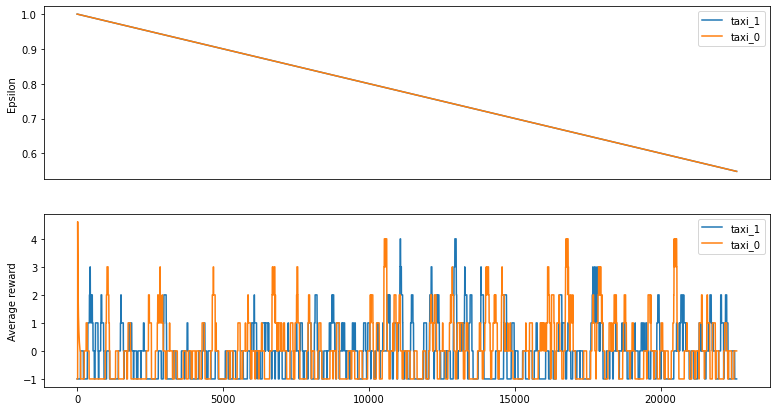

In [14]:
# set up a dictionary of RL decision makers, one for each taxi
rl_agents = {}
for agent_id in taxi_env.get_env_agents():
    rl_agents[agent_id] = create_decentralized_agent(kwargs['algo'], taxi_env, agent_id, kwargs)

# initialize a decentralized controller
decentralized_rl_controller = DecentralizedRlController(env=taxi_env, agents=rl_agents)

# train
total_rewards, agents_epsilons = decentralized_rl_controller.train(render=False, max_iteration=max_iteration,
                                                                   max_episode=max_episode)

# plot training process results
plot_multi_taxi_learning_curve(total_rewards, agents_epsilons)

### Learning Curve of a Successfully Trained Decentralized Controller


![](tmp/2022_06_13__12_15_53_x/learning_curve_2022_06_13__12_15_53.png)

### Evaluate the Controller with env.render()

... initialize a decentralized dqn agent for agent taxi_0 ...
... loading checkpoint ...
... loading checkpoint ...
... load a decentralized dqn agent for agent taxi_0 ...
... initialize a decentralized dqn agent for agent taxi_1 ...
... loading checkpoint ...
... loading checkpoint ...
... load a decentralized dqn agent for agent taxi_1 ...


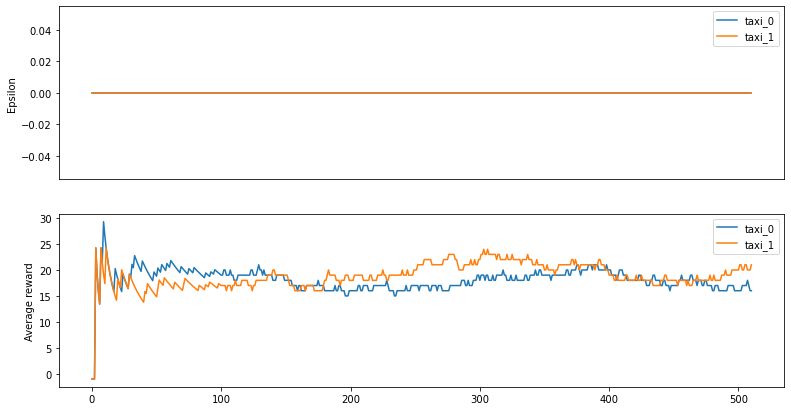

+---------+
|P: : : : |
| :_: : :P|
| :_: : : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,1), Collided: False
Taxi1-RED: Fuel: inf, Location: (2,1), Collided: False
Passenger1: Location: (0, 0), Destination: pickup only!
Passenger2: Location: (1, 4), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+---------+
|P: : : : |
| :_:_: :P|
| : : : : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,2), Collided: False
Taxi1-RED: Fuel: inf, Location: (1,1), Collided: False
Passenger1: Location: (0, 0), Destination: pickup only!
Passenger2: Location: (1, 4), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+---------+
|P:_: : : |
| : : :_:P|
| : : : : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,3), Collided: False
Taxi1-RED: Fuel: inf, Location: (0,1), Collided: Fal

In [15]:
# load agents and create controller
load_agent = True
if load_agent:
    kwargs['chkpt_dir'] = './tmp/2022_06_13__12_15_53_x'  # path to experiment directory
    rl_agents = {}
    for agent_id in taxi_env.get_env_agents():
        rl_agents[agent_id] = create_decentralized_agent(kwargs['algo'], taxi_env, agent_id, kwargs, load_agent=load_agent)
    decentralized_rl_controller = DecentralizedRlController(env=taxi_env, agents=rl_agents)
    eval_total_rewards = decentralized_rl_controller.evaluate(render=False, max_iteration=100, max_episode=100)
    plot_multi_taxi_learning_curve(eval_total_rewards)

# evaluate
eval_total_rewards = decentralized_rl_controller.evaluate(render=True, max_iteration=10, max_episode=1)

## Centralized Reinfrocement Learning Controller

The implementation's architecture is depicted in the diagram below, where the end result is a `CentralizedRLController` which is MAC complatible  

![](assets/centralized_rl_controller_inheritance.drawio.png)

The `train()` function of the centralized RL controller class also has a few important aspects it is worth talk about, here is its skeleton

```python
def train(self, render=False, max_iteration=None, max_episode=1):
    ...
    for episode in tqdm(range(max_episode)):
        ...
        decomposed_done = {self.agent_name: False}
        observation = self.env.get_env().reset()

        while not decomposed_done[self.agent_name]:
            ...

            # decompose the observation
            decomposed_observation = self.decompose_observation(observation)

            # get the central agent action
            decomposed_action = self.get_training_joint_action(decomposed_observation)

            # compute the action for each agent
            joint_action = self.decode_action(decomposed_action)

            # perform the joint action
            observation_, reward, done, info = self.perform_joint_action(joint_action)

            # decompose observation_ and reward
            decomposed_observation_ = self.decompose_observation(observation_)
            decomposed_reward = self.decompose_reward(reward)
            decomposed_done[self.agent_name] = done['__all__']

            # store the transition
            self.store_decomposed_transition(decomposed_observation, decomposed_action, decomposed_reward,
                                             decomposed_observation_, decomposed_done)
            ...
            # erform learning for the central agent
            self.learn()

            ...
            # step the state forward
            observation = observation_
            ...
    return stuff_for_analysis
```

__Notes:__
- The `observation` received from the environment (observations) are decomposed into a high-dimensional single observation using the `decompose_observation()` function before transfered to the central-agent's `get_training_joint_action()` which retuns an action in a combined high-dimensional action-space.
- Then, the central-agent's action is decoded with the `decode_action()` function into a `joint_action` that is later used for stepping the environment.
- The new observations and rewards are also decomposed to high-dimensional spaces and then a decomposed transition is stored.
- There are a lot of ways to decompose the rewards received from the environment to individual players into a single reward for a central agent, we used $$r_{decomposed}^{t}=\sum_{i=1}^{\text{#-individuals}}r_i^t$$ but one can also use the averaged reward or some other decomposition.

- The learning process is happening at once, with no loop, because there is only one agent.



## Running a Centralized RL Controller for the Multi-Taxi Domain
### Setting up the parameters

In [16]:
# multi_taxi parameters
num_taxis = 2
num_passengers = 2
can_see_others = False
domain_map = simple_MAP
pickup_only = True

# DQN parameters
kwargs = {
    'gamma': 0.99,
    'epsilon': 1.0,
    'lr': 1e-4,
    'mem_size': 100000,
    'batch_size': 8,
    'eps_min': 0.01,
    'eps_dec': 2e-5,
    'replace': 4000,
    'algo': 'dqn',
    'env_name': 'multi_taxi',
    'chkpt_dir': './'
}

# controller parameters
max_iteration = 100
max_episode = 300

### Initialize the Multi Taxi environment

In [17]:
# setting up the environment
taxi_env = MultiTaxiEnv(num_taxis=num_taxis, num_passengers=num_passengers, can_see_others=can_see_others,
                        domain_map=domain_map, pickup_only=pickup_only)

# wrap environment to be MAC compatible
taxi_env = EnvWrappperMultiTaxi(taxi_env)

# render
taxi_env.render()

+---------+
| : : : : |
| : : : : |
|_: : : : |
| : : : : |
|P: :P: :_|
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2,0), Collided: False
Taxi1-RED: Fuel: inf, Location: (4,4), Collided: False
Passenger1: Location: (4, 2), Destination: pickup only!
Passenger2: Location: (4, 0), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]


### Create the Controller and Train the Central-Agent

100%|█████████████████████████████████████████| 300/300 [00:59<00:00,  5.05it/s]


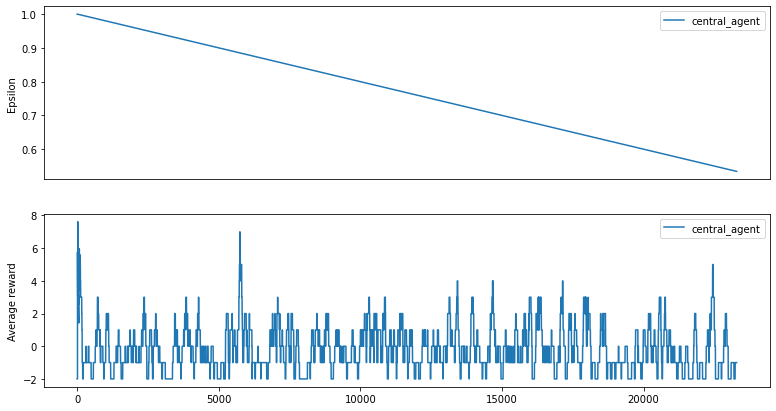

In [18]:
# set up a dictionary of a single decision makers, one for all taxi
central_rl_agent = {}
agent_id = 'central_agent'
central_rl_agent[agent_id] = create_centralized_agent(kwargs['algo'], taxi_env, agent_id, kwargs)

# initialize a centralized controller
centralized_rl_controller = CentralizedRlController(env=taxi_env, central_agent=central_rl_agent)

# train
total_reward, agent_epsilon = centralized_rl_controller.train(render=False, max_iteration=max_iteration,
                                                              max_episode=max_episode)

# plot training process results
plot_multi_taxi_learning_curve(total_reward, agent_epsilon)



### Learning Curve of a Successfully Trained Centralized Controller


![](tmp/2022_06_13__13_06_42_x/learning_curve_2022_06_13__13_06_42.png)

### Evaluate the Controller with env.render()

... initialize a centralized dqn agent for agent central_agent ...
... loading checkpoint ...
... loading checkpoint ...
... load a centralized dqn agent for agent central_agent ...


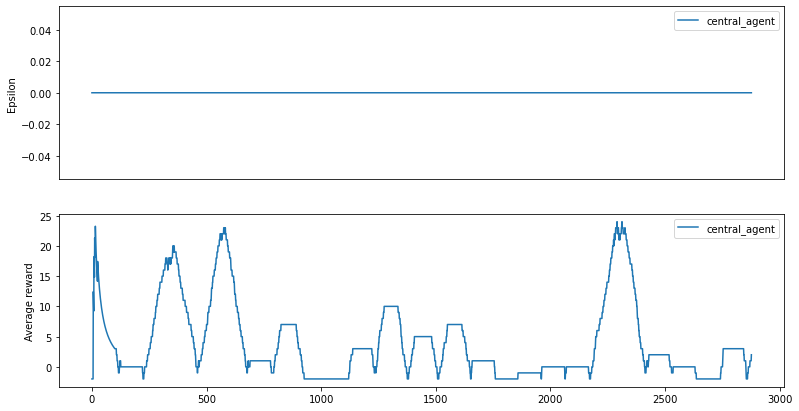

+---------+
| : : : : |
|P: :_: : |
|P: : : : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,2), Collided: False
Taxi1-RED: Fuel: inf, Location: (1,0), Collided: False
Passenger1: Location: (2, 0), Destination: pickup only!
Passenger2: Location: (1, 0), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+---------+
| : : : : |
| : : : : |
|P: :_: : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2,2), Collided: False
Taxi1-RED: Fuel: inf, Location: (1,0), Collided: False
Passenger1: Location: (2, 0), Destination: pickup only!
Passenger2: Location: Taxi2, Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 4]
+---------+
| : : : : |
| : : : : |
|P:_: : : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2,1), Collided: False
Taxi1-RED: Fuel: inf, Location: (1,0), Collided: Fals

In [19]:
# load agents and create controller
load_agent = True
if load_agent:
    kwargs['chkpt_dir'] = './tmp/2022_06_13__13_06_42_x'  # path to experiment directory
    
    kwargs['env_name'] = 'multi_taxi'
    central_rl_agent = {}
    agent_id = 'central_agent'
    central_rl_agent[agent_id] = create_centralized_agent(kwargs['algo'], taxi_env, agent_id, kwargs, 
                                                          load_agent=load_agent)
    centralized_rl_controller = CentralizedRlController(env=taxi_env, central_agent=central_rl_agent)
    eval_total_rewards = centralized_rl_controller.evaluate(render=False, max_iteration=100, max_episode=100)
    plot_multi_taxi_learning_curve(eval_total_rewards)

# evaluate
eval_total_rewards = centralized_rl_controller.evaluate(render=True, max_iteration=20, max_episode=1)

## Speaker-Listener Domain

In this domain we use the __centralized and independent learners with DQN for discrete actions only__. For continous actions, we should use an algorithm which support them, i.e. from the policy gradient family.
For this domain, we should add the following imports:

In [20]:
from pettingzoo.mpe import simple_speaker_listener_v3
from pettingzoo.utils.wrappers import BaseParallelWraper
from mac.environments.env_wrapper import EnvWrappper
from src.utils_controller_ssl import (DecentralizedRlController, CentralizedRlController,
                                  create_decentralized_agent, create_centralized_agent)

For the multi-agent control library to work with petting zoo, __We define a wrapper called EnvWrapperSSL__, in which we should define the methods 'step' and 'observation_to _dict'

In [21]:
class EnvWrapperSSL(EnvWrappper):
        def __init__(self, env):

            # get action space of each agent
            action_spaces = {
                agent_id: env.action_space(agent_id) for agent_id in env.possible_agents
            }

            # get observation space for each agent
            observation_spaces = {
                agent_id: env.observation_space(agent_id) for agent_id in env.possible_agents
            }

            super().__init__(env, env.possible_agents, observation_spaces, action_spaces)

        def step(self, joint_action):
            return self.env.step(joint_action)

        def observation_to_dict(self, obs):
            return obs
        
        def render(self):
            return self.env.render()

We now pack our training and evaluation scripts in a function which can fit the new domain, and hopefully is even more general:

In [22]:
def train_and_eval(env, decentralized_control_simulation, network='dqn'):
    # set up and run the controller
    if decentralized_control_simulation:
        # set up a dictionary of RL decision makers, one for each taxi
        agents = {}
        for agent_id in env.get_env_agents():
            agents[agent_id] = create_decentralized_agent(network, env, agent_id, kwargs)

        # initialize a decentralized controller
        decentralized_rl_controller = DecentralizedRlController(env=env, agents=agents)

        # train
        total_rewards, agents_epsilons = decentralized_rl_controller.train(render=False, max_iteration=max_iteration,
                                                                           max_episode=max_episode)

        # plot training process results
        #plot_multi_taxi_learning_curve(total_rewards, agents_epsilons, filename=filename)

        # evaluate
        #eval_total_rewards = decentralized_rl_controller.evaluate(render=True, max_iteration=10, max_episode=3)

    else:
        # set up a dictionary of a single decision makers, one for all taxi
        central_agent = {}
        agent_id = 'central_agent'
        central_agent[agent_id] = create_centralized_agent(network, env, agent_id, kwargs)

        # initialize a centralized controller
        centralized_rl_controller = CentralizedRlController(env=env, central_agent=central_agent)

        # train
        total_reward, agent_epsilon = centralized_rl_controller.train(render=False, max_iteration=max_iteration,
                                                                      max_episode=max_episode)

        # plot training process results
        #plot_multi_taxi_learning_curve(total_reward, agent_epsilon, filename=filename)

        # evaluate
        #eval_total_rewards = centralized_rl_controller.evaluate(render=True, max_iteration=10, max_episode=3)

Now we create the wrapped simple speaker listener environment:

In [23]:
ssl_env = simple_speaker_listener_v3.parallel_env(max_cycles=5)
ssl_env = EnvWrapperSSL(ssl_env)
observations = ssl_env.get_env().reset()

And we run our function on the new enviroinment, one with the centralized training, and one with the decentralized one (each with its own parameters):

In [24]:
# DQN parameters
kwargs = {
    'gamma': 0.99,
    'epsilon': 1.0,
    'lr': 1e-4,
    'mem_size': 100000,
    'batch_size': 8,
    'eps_min': 0.01,
    'eps_dec': 2e-5,
    'replace': 4000,
    'algo': 'dqn',
    'env_name': 'speaker_listener',
    'chkpt_dir': './'
}

# controller parameters
max_iteration = 100
max_episode = 300

In [25]:
train_and_eval(env=ssl_env, network='dqn', decentralized_control_simulation=True)

100%|█████████████████████████████████████████| 300/300 [00:07<00:00, 42.50it/s]


In [26]:
# DQN parameters
kwargs = {
    'gamma': 0.99,
    'epsilon': 1.0,
    'lr': 1e-4,
    'mem_size': 100000,
    'batch_size': 8,
    'eps_min': 0.01,
    'eps_dec': 2e-5,
    'replace': 4000,
    'algo': 'dqn',
    'env_name': 'speaker_listener',
    'chkpt_dir': './'
}

# controller parameters
max_iteration = 100
max_episode = 300

In [27]:
train_and_eval(env=ssl_env, network='dqn', decentralized_control_simulation=False)

100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 60.28it/s]
